In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
# import io
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tabulate import tabulate
from PIL import Image
from scipy.fft import fft2, fftshift, ifft2, ifftshift
from skimage import io, color, img_as_float

In [113]:
def detect_noise(image_path):
    # Load the image
    img = cv2.imread(image_path, 0)

    # Calculate the histogram
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    # Plot the histogram
    plt.bar(range(256), hist.ravel())
    plt.show()

    # Identify the type of noise based on the histogram
    if hist[0] > 0 and hist[-1] > 0:
        return 'Salt-and-pepper noise'

    # Calculate the variance of the image
    var = np.var(img)

    # Try different values of sigma between 1 and 30
    best_sigma = -1
    best_filtered_var = float('inf')
    for sigma in range(1, 31):
        # Apply Gaussian filter to the image
        filtered_img = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma, sigmaY=sigma)

        # Calculate the variance of the filtered image
        filtered_var = np.var(filtered_img)

        # Check if the variance of the filtered image is significantly lower than the variance of the original image
        if filtered_var < var * 0.1 and filtered_var < best_filtered_var:
            best_filtered_var = filtered_var
            best_sigma = sigma

    # If a significant reduction in variance was found, return the corresponding sigma
    if best_sigma != -1:
        return f'Gaussian noise with sigma = {best_sigma}'
    else:
        # Calculate the mean and standard deviation of the image
        mean = np.mean(img)
        stddev = np.std(img)

        # Determine the type of noise based on the mean and standard deviation
        if stddev < 10:
            return 'Salt-and-pepper noise'
        else:
                # Calculate the mean and standard deviation of the image
                mean = np.mean(img)
                stddev = np.std(img)

                # Try different values of sigma between 1 and 10
                for sigma in range(1, 11):
                    # Calculate the threshold for determining Gaussian noise
                    threshold = sigma * stddev

                    # Count the number of pixels with absolute difference greater than the threshold
                    diff = np.abs(img - mean)
                    num_diff_pixels = np.sum(diff > threshold)

                    # Calculate the percentage of pixels with absolute difference greater than the threshold
                    pct_diff_pixels = num_diff_pixels / img.size

                    # If the percentage is above a certain threshold, assume Gaussian noise
                    if pct_diff_pixels > 0.05:
                        return f'Gaussian noise Detected , the sigma is used for test is = {sigma}'

                # If no Gaussian noise is detected, return None
                return 'NO Noise detected !!'


1.  Load the image using OpenCV's imread function.
2.  Calculate the histogram of the image using OpenCV's calcHist function and plot the histogram using matplotlib's bar function.
3.  Identify the type of noise based on the shape of the histogram. If both the first and last bins of the histogram have non-zero values, the function identifies the noise as salt-and-pepper noise.
4.  If salt-and-pepper noise is not detected, the function applies a Gaussian filter to the image with different values of sigma ranging from 1 to 30. For each value of sigma, the function calculates the variance of the filtered image and checks if it is significantly lower than the variance of the original image. If a significant reduction in variance is found, the function returns the corresponding sigma as the level of Gaussian noise present in the image.
5.  If no significant reduction in variance is found, the function calculates the mean and standard deviation of the image. If the standard deviation is less than 10, the function identifies the noise as salt-and-pepper noise. Otherwise, the function tries different values of sigma between 1 and 10 to determine the presence of Gaussian noise. For each value of sigma, the function calculates the threshold for determining Gaussian noise and counts the number of pixels with absolute difference greater than the threshold. If the percentage of such pixels is above a certain threshold, the function identifies the noise as Gaussian noise with the corresponding sigma value.
6.  If no noise is detected, the function returns "NO Noise detected !!"


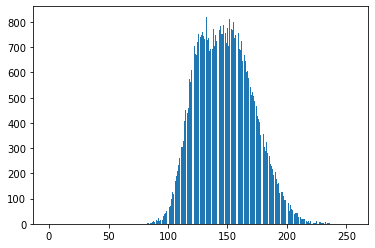

'Gaussian noise Detected , the sigma is used for test is = 1'

In [114]:
detect_noise('land.png')

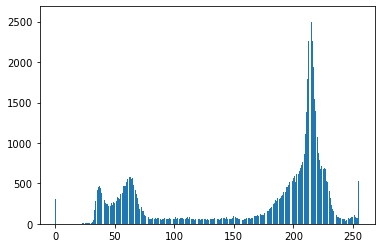

'Salt-and-pepper noise'

In [116]:
detect_noise('1.png')

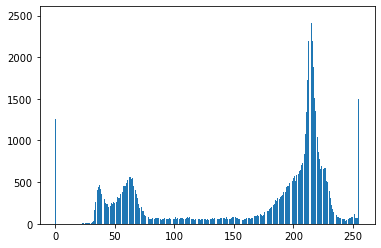

'Salt-and-pepper noise'

In [117]:
detect_noise('2.png')

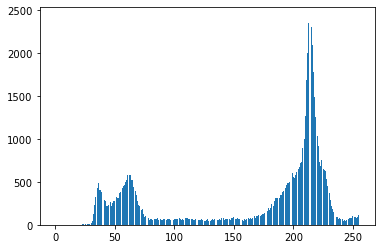

'Gaussian noise Detected , the sigma is used for test is = 1'

In [118]:
detect_noise('3.png')

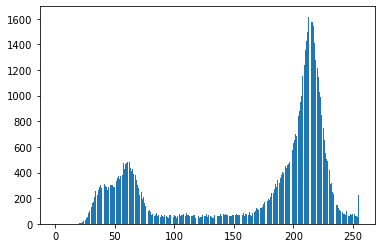

'Gaussian noise Detected , the sigma is used for test is = 1'

In [119]:
detect_noise('4.png')

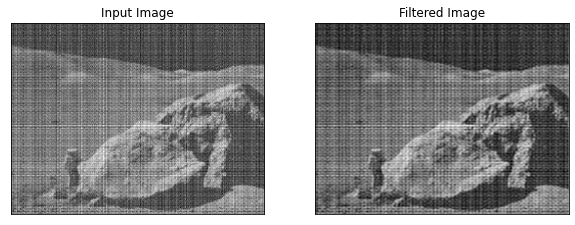

In [109]:
#try low pass filter ! 
# Load the image
img = cv2.imread('land.png', 0)

# Perform Fourier transform on the image
f = fft2(img)
fshift = fftshift(f)

# Calculate the magnitude spectrum of the Fourier domain image
magnitude_spectrum = 20 * np.log(np.abs(fshift))

# Define a low-pass filter
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2
mask = np.zeros((rows, cols), np.uint8)
r = 80
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 1

# Apply the mask to the Fourier domain image
filtered_spectrum = fshift * mask

# Shift the filtered Fourier domain image back to its original position
filtered_fshift = ifftshift(filtered_spectrum)

# Apply inverse Fourier transform to get the filtered image
filtered_img = np.abs(ifft2(filtered_fshift))

# Display the original and filtered images side by side
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 2, 2), plt.imshow(filtered_img, cmap='gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()


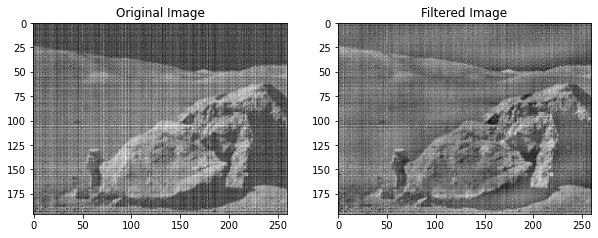

In [131]:
#try treshhold filter !
# Load the image and convert it to grayscale
# img = img_as_float(io.imread('land.png'))
gray_img =  cv2.imread("land.png", cv2.IMREAD_GRAYSCALE)

# Compute the Fourier transform of the image
f = fftshift(fft2(gray_img))

# Compute the magnitude spectrum of the Fourier transform
magnitude_spectrum = np.abs(f)

# Compute the median of the magnitude spectrum to estimate the noise level
noise_level = np.median(magnitude_spectrum)

# Threshold the magnitude spectrum to detect the noise
threshold = noise_level * 35# adjust the threshold as needed
mask = magnitude_spectrum > threshold

# Apply a bandpass filter to remove the noise
f_filtered = f.copy()
f_filtered[mask] = 0

# Compute the inverse Fourier transform of the filtered spectrum
filtered_img = np.real(ifft2(ifftshift(f_filtered)))

# Display the original and filtered images
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(gray_img, cmap='gray')
ax0.set_title('Original Image')
ax1.imshow(filtered_img, cmap='gray')
ax1.set_title('Filtered Image')
plt.show()

# Save the filtered image
# io.imsave('filtered_image.jpg', filtered_img)


The code above  first loads an image and converts it to grayscale. It then computes the Fourier transform of the image, computes the magnitude spectrum of the Fourier transform, and estimates the noise level as the median of the magnitude spectrum. It then thresholds the magnitude spectrum to detect the noise and applies a bandpass filter to remove the noise. Finally, it computes the inverse Fourier transform of the filtered spectrum to obtain the denoised image, and displays the original and filtered images side by side.